This Notebook is for removing outliers from our dataset. Currently we remove businesses that have extremely high consumer and merchant frauds .

In [10]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, to_date, when, concat, lit
from pyspark.sql.types import TimestampType
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

spark = SparkSession.builder \
    .appName("green preprocessing") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.parquet.cacheMetadata", "true") \
    .config("spark.sql.session.timeZone", "Etc/UTC") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [11]:
path1 = "../../../data/insights/joined.parquet"
df = spark.read.parquet(path1)
df.show(5)
df.printSchema()
print("length:",df.count())

df_pandas = df.toPandas()
segments = df['segment'].unique()


+------------+--------------------+-------------+---------+----------------------------------+-------------------+----------------------------------+--------------------------+----------------+---------------------+-------------------+--------------------------------+---------------------------+------------------+---------------------------------+--------------------+--------------------+
|merchant_abn|                name|revenue_level|take_rate|average_merchant_fraud_probability|number_of_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|number_of_orders|average_cost_of_order|number_of_postcodes|avg_total_weekly_personal_income|avg_total_weekly_fam_income|    avg_median_age|avg_num_of_consumers_per_postcode|merchant_description|             segment|
+------------+--------------------+-------------+---------+----------------------------------+-------------------+----------------------------------+--------------------------+----------------+---------------------+-

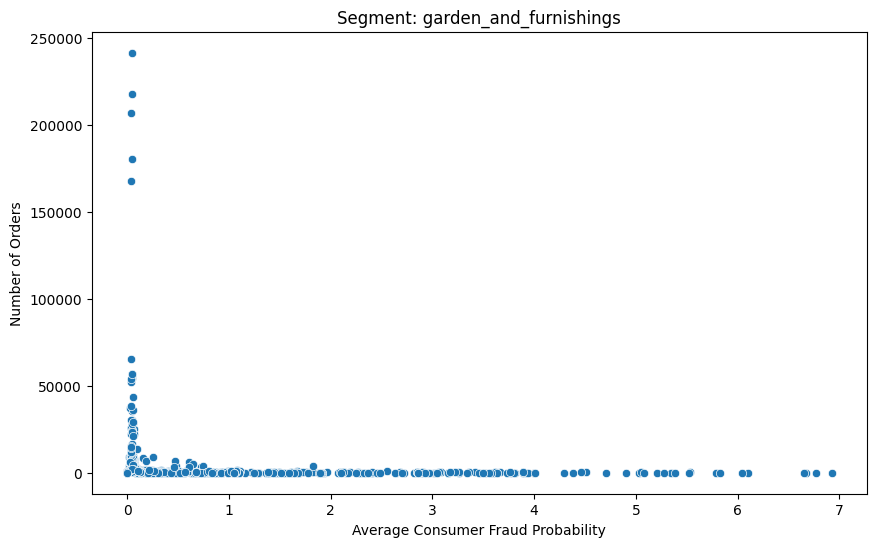

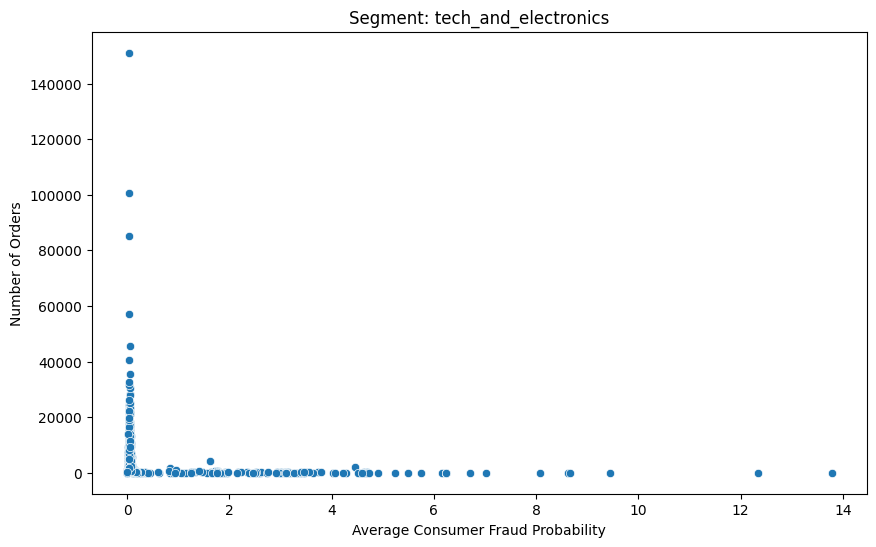

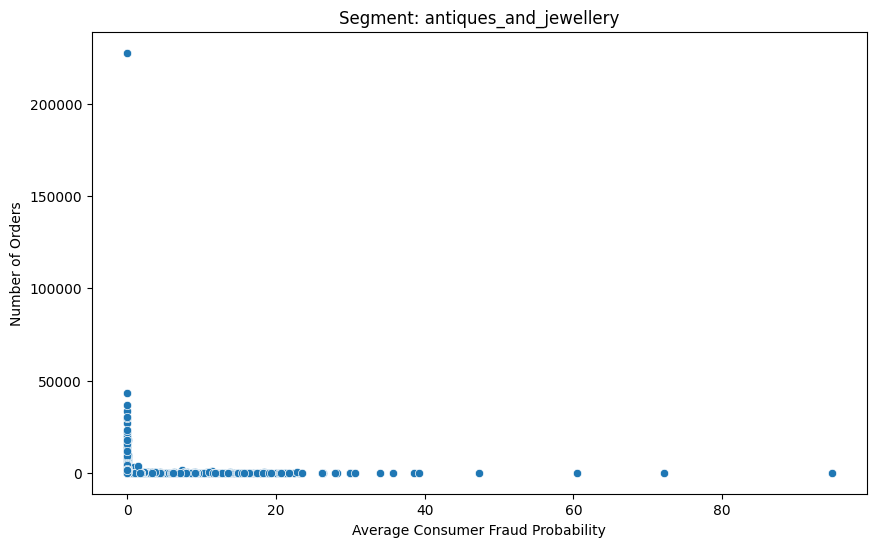

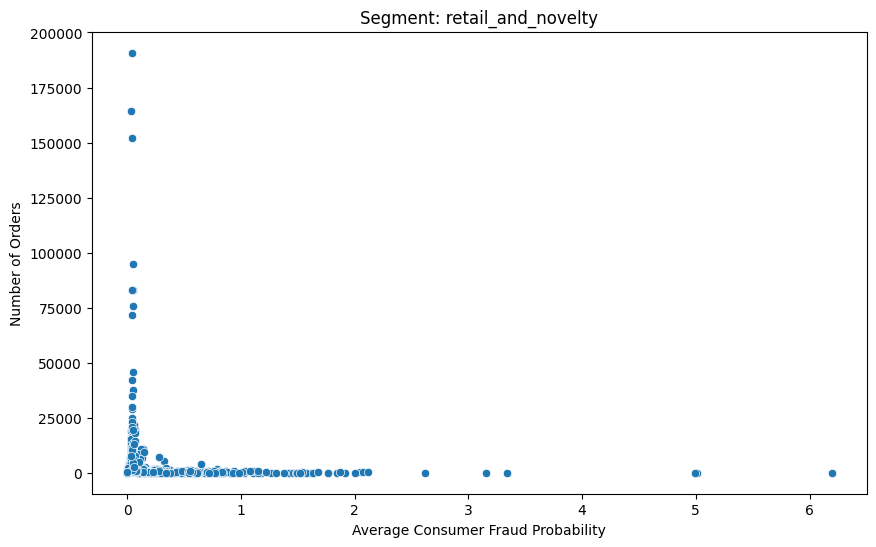

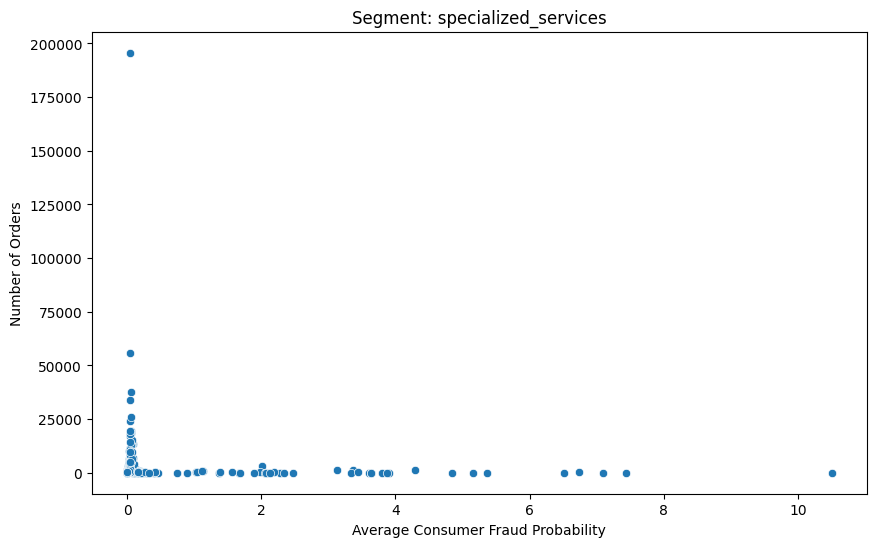

,merchant_abn,name,revenue_level,take_rate,average_merchant_fraud_probability,number_of_consumers,average_consumer_fraud_probability,number_of_repeat_consumers,number_of_orders,average_cost_of_order,number_of_postcodes,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_num_of_consumers_per_postcode,merchant_description,segment
0,11974270529,Dui Fusce Corp.,b,3.90,0.0,432,2.912395,7.0,439,2508.827267,439,786.789294,1967.249431,42.812073,1.089330,"furniture, home furnishings and equipment shop...",garden_and_furnishings
1,12741443840,Tincidunt Aliquam Limited,a,5.55,0.0,373,3.667354,8.0,381,3059.581391,381,773.307087,1925.461942,43.078740,1.107558,"equipment, tool, furniture, and appliance rent...",garden_and_furnishings
2,13248824465,Convallis Erat Limited,b,4.99,0.0,127,2.717222,NaN,127,2590.397717,127,772.007874,1957.913386,43.118110,1.016000,"furniture, home furnishings and equipment shop...",garden_and_furnishings
3,13467303030,Duis LLP,a,5.51,0.0,6,2.333733,NaN,6,1590.230000,6,794.583333,2203.666667,39.166667,1.000000,tent and awning shops,garden_and_furnishings
4,13555086357,Ipsum LLP,b,4.92,0.0,370,2.187892,NaN,370,2244.317730,370,801.218919,2000.228378,42.841892,1.078717,"furniture, home furnishings and equipment shop...",garden_and_furnishings
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,94380689142,Aliquet Ltd,b,3.77,0.0,52,3.635033,NaN,52,3770.339038,52,787.932692,2014.461538,42.259615,1.040000,motor vehicle supplies and new parts,specialized_services
491,96381568282,Quisque LLC,e,0.24,0.0,117,0.266769,NaN,117,396.298120,117,781.632479,1944.303419,43.884615,1.026316,health and beauty spas,specialized_services
492,98203593138,Suscipit Nonummy Limited,a,6.05,0.0,56,0.888289,NaN,56,1254.223750,56,815.125000,2043.383929,42.901786,1.000000,motor vehicle supplies and new parts,specialized_services
493,99063901069,Pede Ultrices Institute,b,4.87,0.0,40,0.324582,NaN,40,411.908500,40,789.025000,2043.537500,43.250000,1.000000,health and beauty spas,specialized_services


In [14]:
import pandas as pd

# Initialize an empty list to hold the outliers
outliers_list = []

# Define a function to calculate upper bound outliers
def get_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    return df[df[column_name] > upper_bound]

for segment in segments:
    # Filter the dataframe for each segment
    segment_df = df_pandas[df_pandas['segment'] == segment]
    
    # Get upper bound outliers for average_consumer_fraud_probability
    consumer_fraud_outliers = get_outliers(segment_df, 'average_consumer_fraud_probability')
    
    # Add them to the list
    outliers_list.extend(consumer_fraud_outliers.to_dict(orient='records'))
    
    # Plotting the scatter plot
    plt.figure(figsize=(10,6))
    sns.scatterplot(x='average_consumer_fraud_probability', y='number_of_orders', data=segment_df)
    plt.title(f'Segment: {segment}')
    plt.xlabel('Average Consumer Fraud Probability')
    plt.ylabel('Number of Orders')
    plt.show()

# Create a DataFrame from the outliers_list
outliers_df = pd.DataFrame(outliers_list)

# Display the outliers DataFrame
display(outliers_df)


/tmp/ipykernel_1997/4285388753.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=outliers, x='average_merchant_fraud_probability', y='average_consumer_fraud_probability', hue='segment', palette='deep')


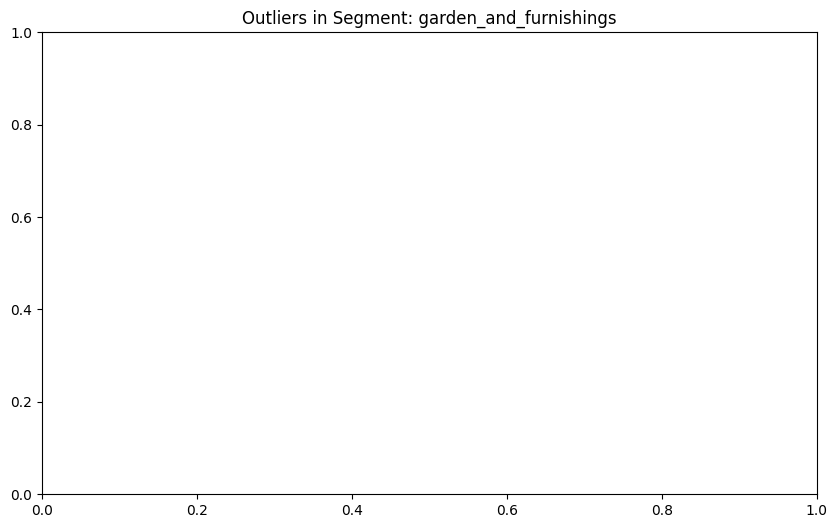

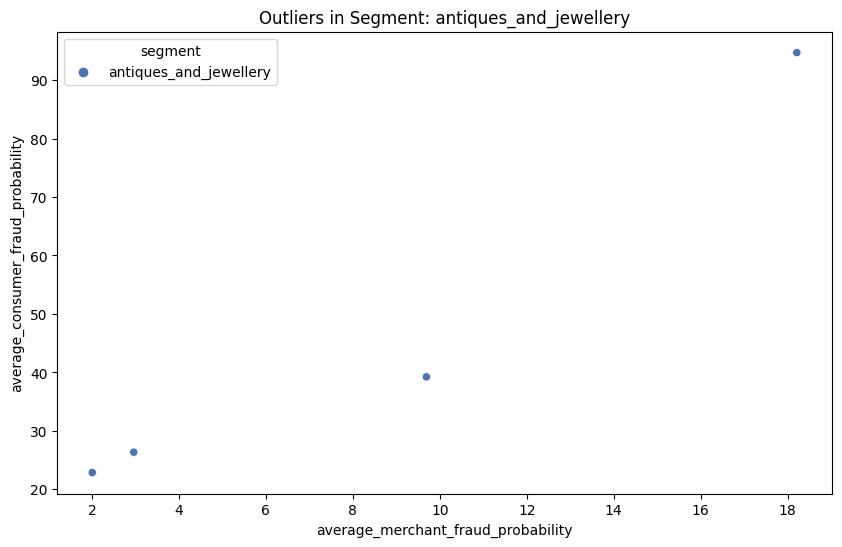

/tmp/ipykernel_1997/4285388753.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=outliers, x='average_merchant_fraud_probability', y='average_consumer_fraud_probability', hue='segment', palette='deep')


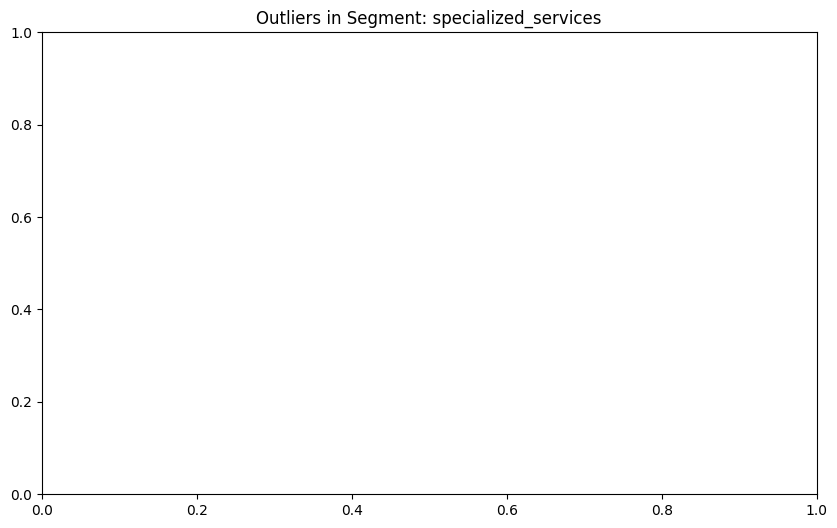

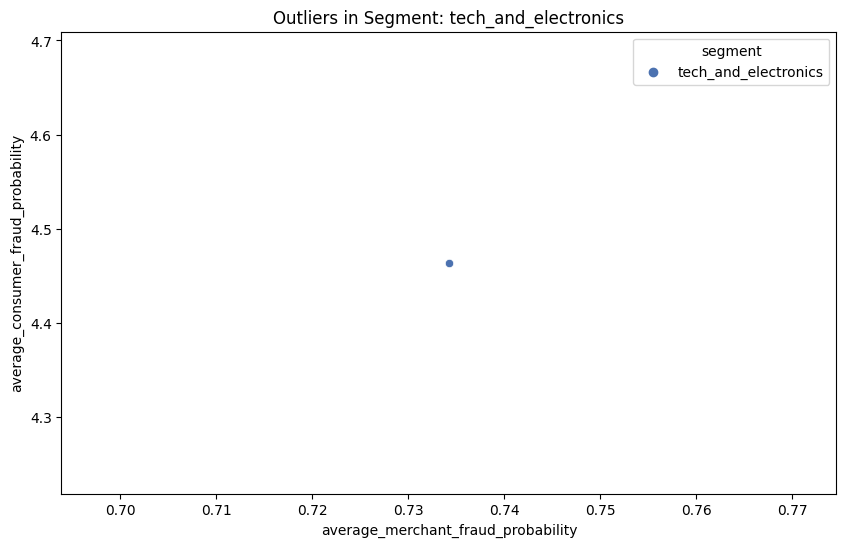

/tmp/ipykernel_1997/4285388753.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=outliers, x='average_merchant_fraud_probability', y='average_consumer_fraud_probability', hue='segment', palette='deep')


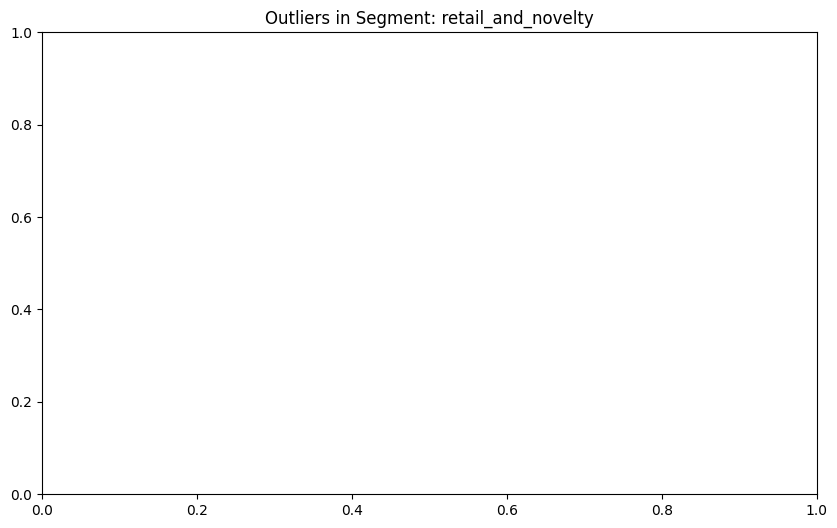

[{'merchant_abn': 11149063370,
  'name': 'Et Arcu Limited',
  'revenue_level': 'b',
  'take_rate': 4.840000152587891,
  'average_merchant_fraud_probability': 2.9603851851851855,
  'number_of_consumers': 54,
  'average_consumer_fraud_probability': 26.333316666666665,
  'number_of_repeat_consumers': nan,
  'number_of_orders': 54,
  'average_cost_of_order': 18012.760185185187,
  'number_of_postcodes': 54,
  'avg_total_weekly_personal_income': 784.0185185185185,
  'avg_total_weekly_fam_income': 1955.8703703703704,
  'avg_median_age': 43.5,
  'avg_num_of_consumers_per_postcode': 1.0,
  'merchant_description': 'art dealers and galleries',
  'segment': 'antiques_and_jewellery'},
 {'merchant_abn': 67264251405,
  'name': 'Elit Dictum Eu Foundation',
  'revenue_level': 'a',
  'take_rate': 6.400000095367432,
  'average_merchant_fraud_probability': 18.2109,
  'number_of_consumers': 1,
  'average_consumer_fraud_probability': 94.7034,
  'number_of_repeat_consumers': nan,
  'number_of_orders': 1,
  '

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

segments = df.select("segment").distinct().rdd.flatMap(lambda x: x).collect()
total_outliers = []
for segment in segments:
    # Filter data for the current segment
    segment_df = df.filter(df.segment == segment).toPandas()  # Convert to pandas for ease of plotting

    # Calculate 1% and 99% percentiles for both variables
    upper_merchant = segment_df['average_merchant_fraud_probability'].quantile(0.95)
    upper_consumer = segment_df['average_consumer_fraud_probability'].quantile(0.95)

    # Filter outliers
    outliers = segment_df[
        (segment_df['average_merchant_fraud_probability'] > upper_merchant) &
        (segment_df['average_consumer_fraud_probability'] > upper_consumer)
    ]
    total_outliers.extend(outliers.to_dict('records'))
    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=outliers, x='average_merchant_fraud_probability', y='average_consumer_fraud_probability', hue='segment', palette='deep')
    plt.title(f'Outliers in Segment: {segment}')
    plt.show()

total_outliers = [row['merchant_abn'] for row in total_outliers]
df = df.filter(~df.merchant_abn.isin(total_outliers))


In [1]:
outliers_list = []  # Initialize an empty list to store the outliers.

for segment in segments:
    # Filter data for the current segment
    segment_df = df.filter(df.segment == segment).toPandas()  # Convert to pandas for ease of plotting

    # Calculate 95% percentiles for both variables
    upper_merchant = segment_df['average_merchant_fraud_probability'].quantile(0.95)
    upper_consumer = segment_df['average_consumer_fraud_probability'].quantile(0.95)

    # Filter outliers
    outliers = segment_df[
        (segment_df['average_merchant_fraud_probability'] > upper_merchant) &
        (segment_df['average_consumer_fraud_probability'] > upper_consumer)
    ]

    # Append the outliers to the list
    outliers_list.extend(outliers.to_dict('records'))

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=outliers, x='average_merchant_fraud_probability', y='average_consumer_fraud_probability', hue='segment', palette='deep')
    plt.title(f'Outliers in Segment: {segment}')
    plt.show()
    print(outliers)

# After the loop, you can create a DataFrame from the outliers_list and remove those rows from the original DataFrame if needed.
outliers_df = pd.DataFrame(outliers_list)


NameError: name 'segments' is not defined